In [88]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, 
                                                  array_to_img, img_to_array, 
                                                  load_img) 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.image as mpimg
import pathlib
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, Xception, InceptionV3
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.utils import plot_model


from src.helper_functions import *
from src.build_models import *

from datetime import datetime
import datetime
import time
from tensorflow.math import confusion_matrix

In [481]:
def create_data_gens1(target_size = (229,229), train_dir = '../../images/Images/train', val_dir = '../../images/Images/val', holdout_dir =  '../../images/Images/test',  batch_size = 16):
    '''
    this is the augmentation configuration we will use for training
    PARAMS: train, val, holdout dirs are directories geared toward the storage of such data

    all images are resized to (229,229)

    RETURNS:
    each image generator in order train, val, holdout
   '''
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            train_dir, 
            shuffle=True, # this is the target directory
            target_size=target_size,  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical',
            seed = 42)  # since we use CategoricalCrossentropy loss, we need categorical labels

    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            val_dir,
            target_size=target_size,
            batch_size=86,
            class_mode='categorical',
            shuffle = False,
            seed = 42)

    h_out = ImageDataGenerator(rescale=1./255)
    # this is a similar generator, for validation data
    holdout_generator = h_out.flow_from_directory(
            holdout_dir,
            target_size=target_size,
            batch_size=99,
            class_mode='categorical',
            shuffle = False,
            seed = 42)
    return train_generator, validation_generator, holdout_generator


In [482]:
train_generator, validation_generator, holdout_generator = create_data_gens1(target_size=(229,229),train_dir = "../images/Images/train",  val_dir = '../images/Images/val', holdout_dir = '../images/Images/test', batch_size = 30)

Found 4164 images belonging to 25 classes.
Found 86 images belonging to 25 classes.
Found 99 images belonging to 25 classes.


In [483]:
model = load_model('models_and_weights/Xception_mod3.h5')
model.load_weights('models_and_weights/weights_Xception_mod3.h5')

In [484]:
pred = model.predict(holdout_generator)
pred2 = model.predict(validation_generator)

In [485]:
metrics = model.evaluate(holdout_generator)
metrics2 = model.evaluate(validation_generator)

KeyboardInterrupt: 

In [ ]:
metrics, metrics2

In [ ]:
prediction_labels, real_labels = get_real_pred(pred, holdout_generator)
prediction_labels2, real_labels2 = get_real_pred(pred2, validation_generator)

In [ ]:
# def plot_missclass(holdout_generator, predictions):
#     x,y = holdout_generator.next()
#     prediction_labels, real_labels = get_real_pred(predictions, holdout_generator)
    
#     incorrect_index = find_missclass_indx(real_labels, prediction_labels)
#     fig, axs = plt.subplots(4,2, figsize = (20,20))
#     ax = axs.flatten()
#     for i, ind in enumerate(incorrect_index):
#         rl = real_labels[ind]
#         pl = prediction_labels[ind]
#         image = x[ind]
#         ax[i].set_title('Actual: {}, \n Predicted: {}'.format(rl, pl))
#         ax[i].imshow(image)
#         ax[i].axis('off')

True- Chihuahua, 
Pred- Shih-Tzu

True- Rhodesian_ridgeback, 
Pred- bloodhound

True- bloodhound, 
Pred- Rhodesian_ridgeback

True- whippet, 
Pred- basset

True- Labrador_retriever, 
Pred- golden_retriever

True- pug, 
Pred- English_setter



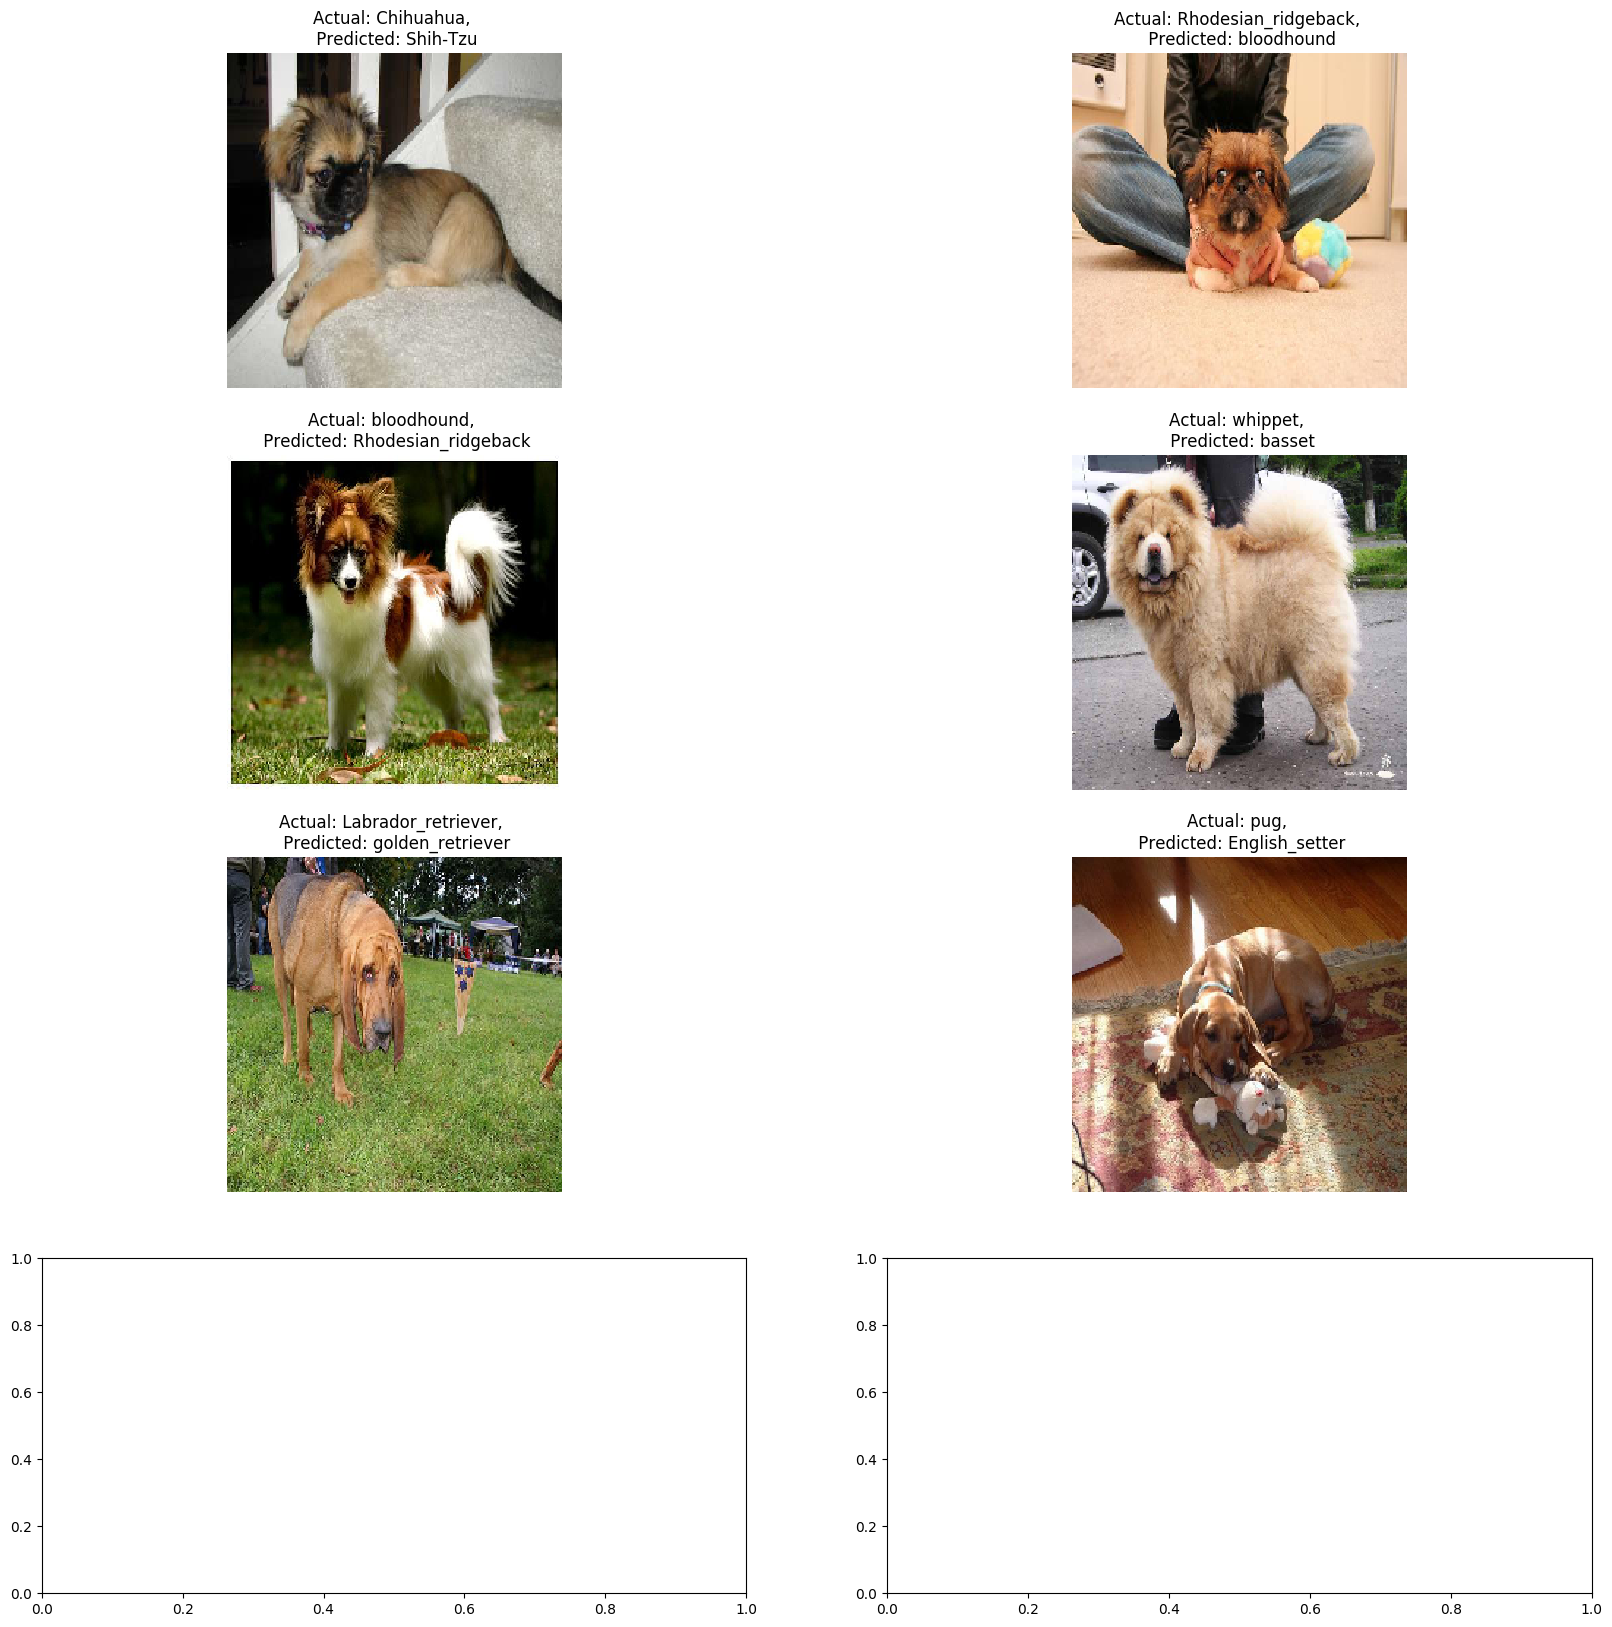

In [480]:
plot_missclass(validation_generator, pred2)

Found 6 images belonging to 1 classes.


In [197]:
rees_dir = '../../../rees/'
r_out = ImageDataGenerator(rescale=1./255)
# this is a similar generator, for validation data
rees_generator = r_out.flow_from_directory(
        rees_dir,
        target_size=(229,229),
        batch_size=6,
        class_mode='categorical')
r_pred = model.predict(rees_generator)
top_five = np.argsort(r_pred[2])[::-1][:5]
labels = holdout_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in top_five]
# real_classes = holdout_generator.classes
# real_labels = [labels[k] for k in real_classes]
# predictions = ['-'.join(lab.split('-')[1:]) for lab in predictions]
# real_labels = ['-'.join(lab.split('-')[1:]) for lab in real_labels]


In [198]:
predictions

['n02113799-standard_poodle',
 'n02100735-English_setter',
 'n02086240-Shih-Tzu',
 'n02085936-Maltese_dog',
 'n02085782-Japanese_spaniel']

In [182]:
r_five_preds = ['n02086240-Shih-Tzu',
 'n02110958-pug',
 'n02096585-Boston_bull',
 'n02088238-basset',
 'n02091134-whippet', 'n02109047-Great_Dane',
 'n02087394-Rhodesian_ridgeback',
 'n02091134-whippet',
 'n02100735-English_setter',
 'n02086240-Shih-Tzu', 'n02113799-standard_poodle',
 'n02100735-English_setter',
 'n02086240-Shih-Tzu',
 'n02085936-Maltese_dog',
 'n02085782-Japanese_spaniel','n02086646-Blenheim_spaniel',
 'n02100735-English_setter',
 'n02086240-Shih-Tzu',
 'n02088238-basset',
 'n02086079-Pekinese','n02091134-whippet',
 'n02100735-English_setter',
 'n02104029-kuvasz',
 'n02087394-Rhodesian_ridgeback',
 'n02099601-golden_retriever','n02087394-Rhodesian_ridgeback',
 'n02099712-Labrador_retriever',
 'n02110958-pug',
 'n02086240-Shih-Tzu',
 'n02100735-English_setter']

In [183]:
len(r_five_preds)

30

In [185]:
d = {}
for i in r_five_preds:
    if i not in d:
        d[i] = 1
    else:
        d[i] += 1

In [186]:
d

{'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 1,
 'n02086079-Pekinese': 1,
 'n02086240-Shih-Tzu': 5,
 'n02086646-Blenheim_spaniel': 1,
 'n02087394-Rhodesian_ridgeback': 3,
 'n02088238-basset': 2,
 'n02091134-whippet': 3,
 'n02096585-Boston_bull': 1,
 'n02099601-golden_retriever': 1,
 'n02099712-Labrador_retriever': 1,
 'n02100735-English_setter': 5,
 'n02104029-kuvasz': 1,
 'n02109047-Great_Dane': 1,
 'n02110958-pug': 2,
 'n02113799-standard_poodle': 1}

In [208]:
def show_imgs(direct, num_imgs=20):
    images = os.listdir(direct)[:num_imgs]
    fig, axs = plt.subplots(2,3)
    ax = axs.flatten()
    for i in range(num_imgs):
        #connect directory to selected breed path and image number
        img = mpimg.imread(direct + '/'+ images[i])
        ax[i].imshow(img)
        ax[i].axis('off')

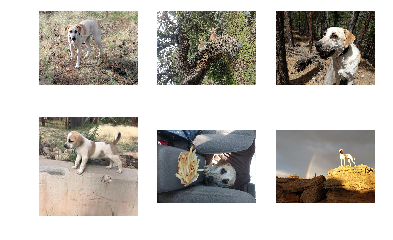

In [209]:
show_imgs(rees_dir+'rees1', num_imgs=6)

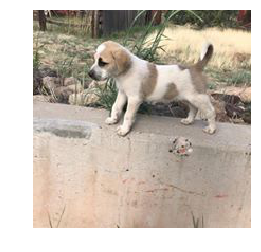

In [104]:
img = mpimg.imread('../../../Downloads/'+'rees.jpeg')
plt.imshow(img)
plt.axis('off');

In [213]:
prediction_labels, real_labels = get_real_pred(pred, holdout_generator)

In [232]:
def get_real_pred(predictions, holdout_generator):
    predicted_class_indices = np.argmax(predictions,axis=1)
    labels = holdout_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    real_classes = holdout_generator.classes
    real_labels = [labels[k] for k in real_classes]
    predictions = ['-'.join(lab.split('-')[1:]) for lab in predictions]
    real_labels = ['-'.join(lab.split('-')[1:]) for lab in real_labels]
    return predictions, real_labels

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  3,  3,  3,
        4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,
        8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12,
       12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16,
       16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 21, 21,
       21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24],
      dtype=int32)

In [383]:
labels = holdout_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
lst_labels = ['-'.join(lab.split('-')[1:]) for lab in list(labels.values())]

In [384]:
from tensorflow.math import confusion_matrix
predicted_class_indices = np.argmax(pred,axis=1)

real_classes = holdout_generator.classes

conf_arry = confusion_matrix(real_classes, predicted_class_indices, num_classes=25)

In [401]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-dark-palette')

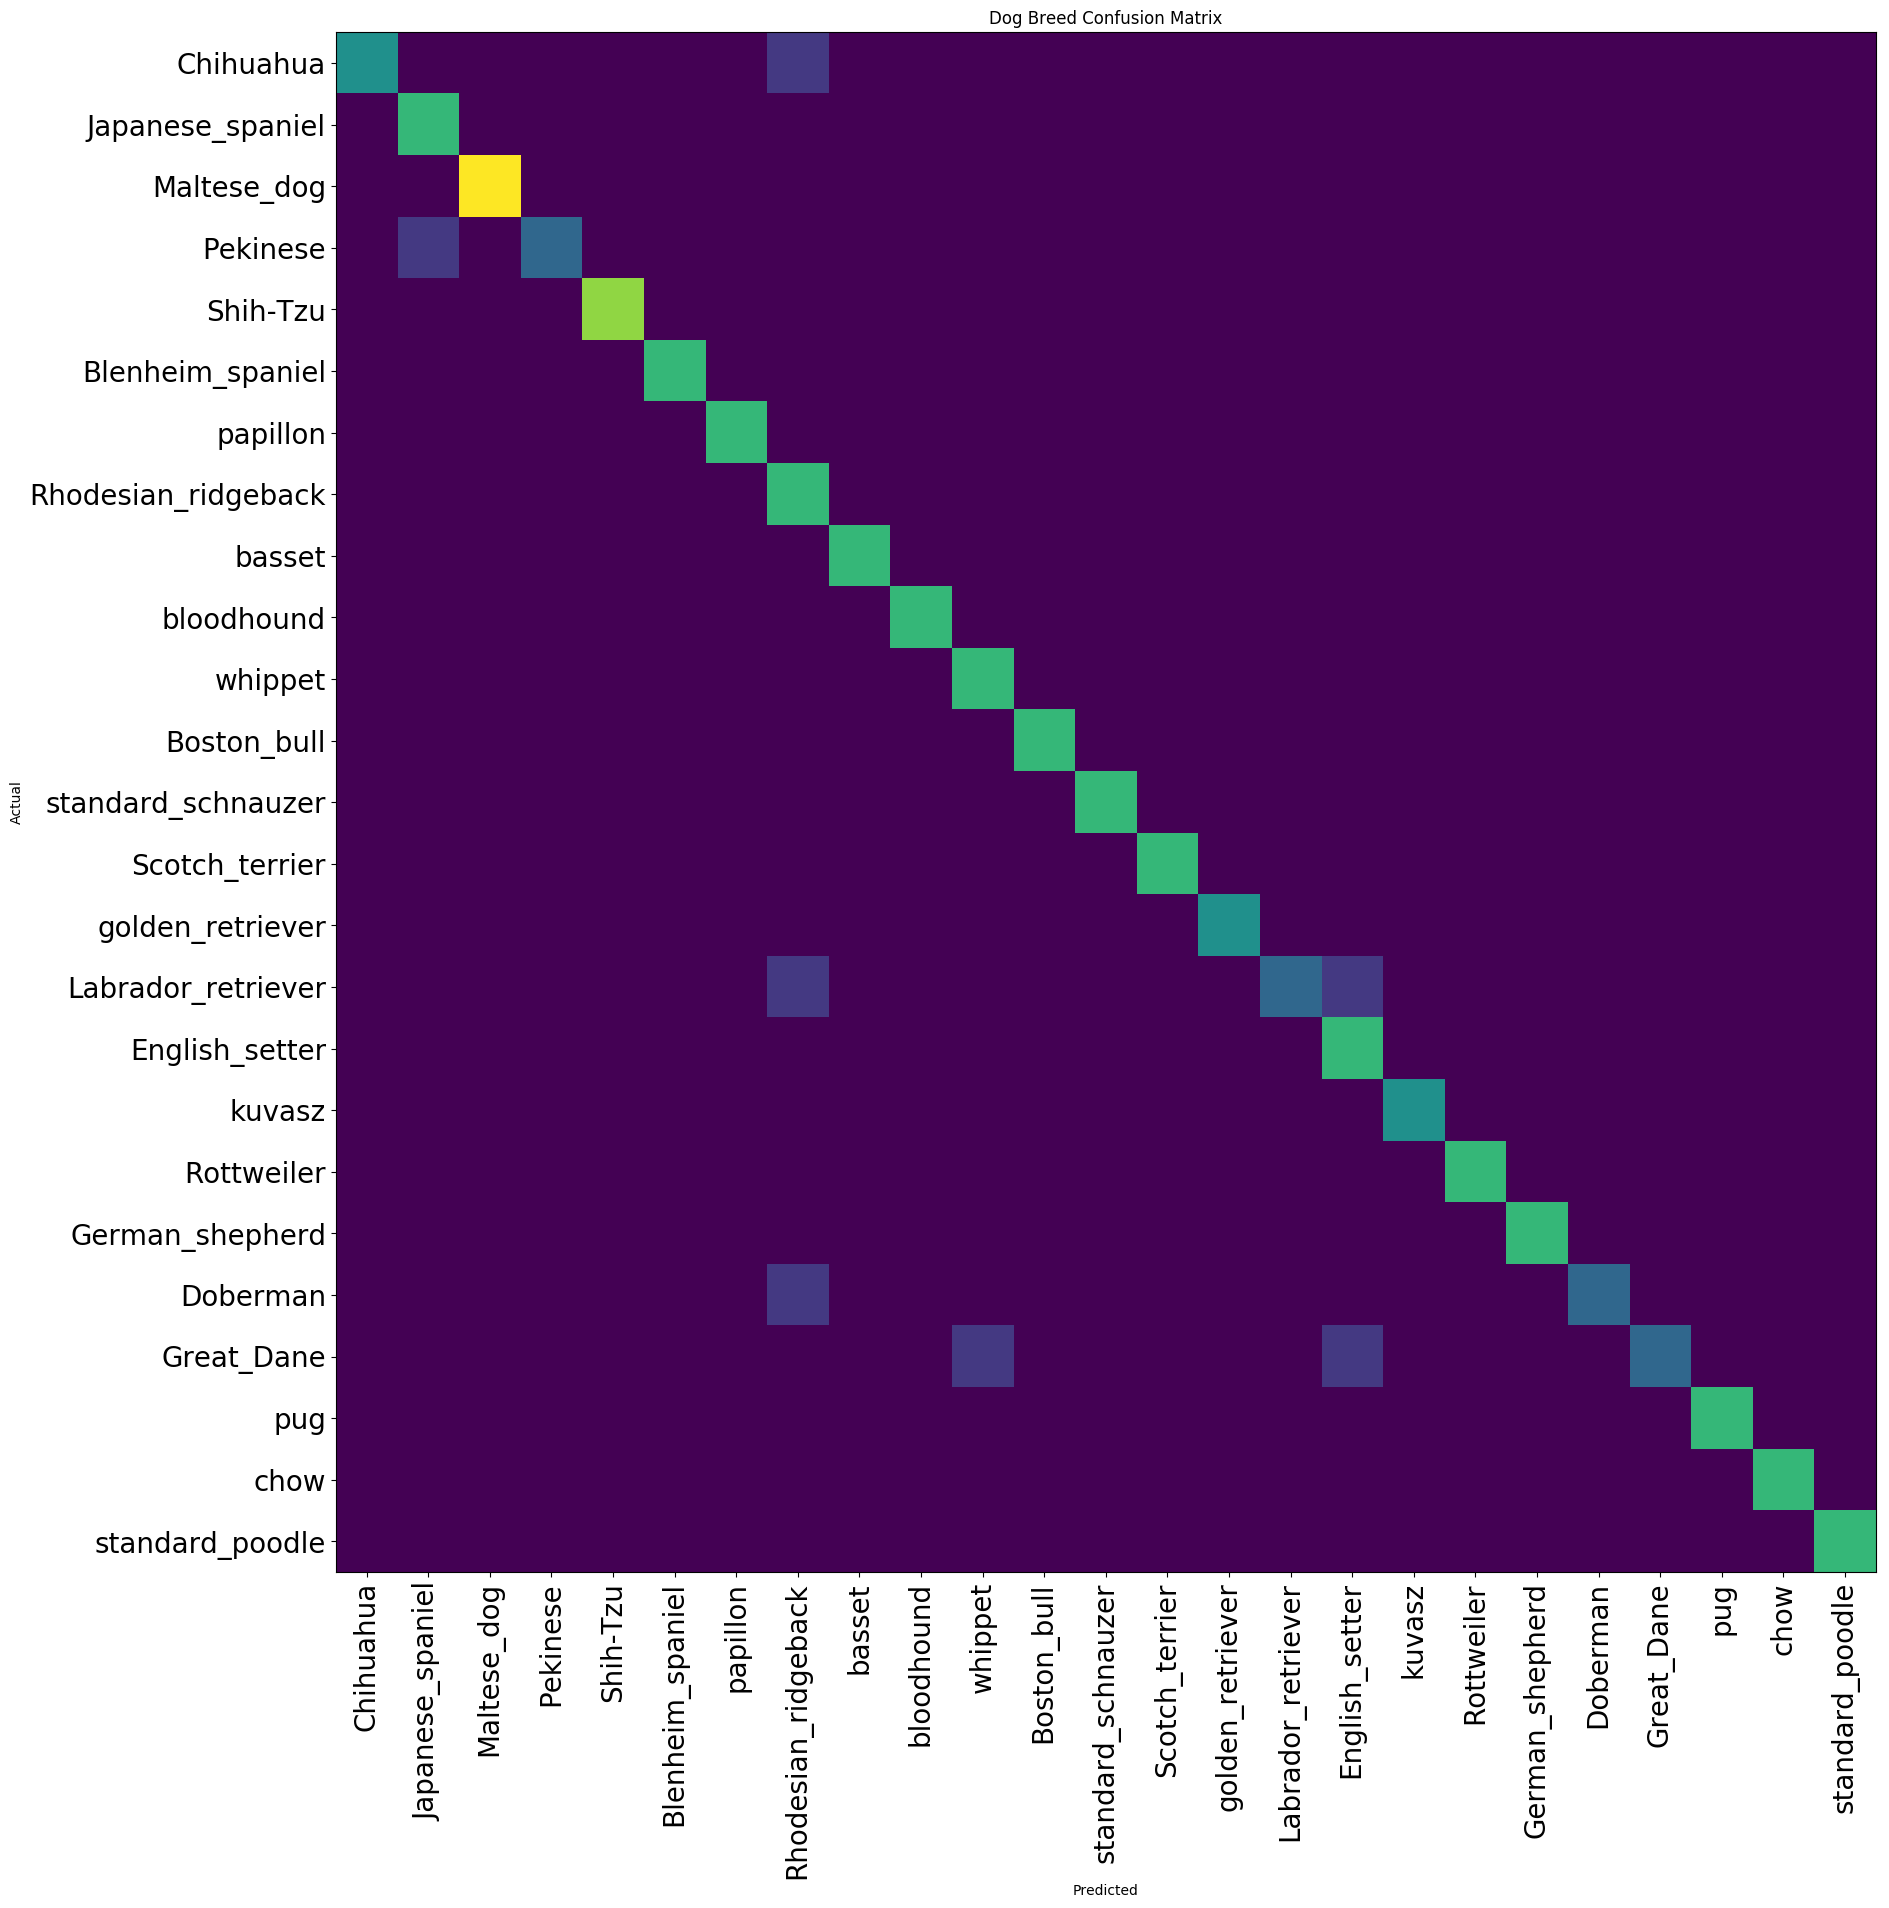

In [402]:
fig, ax = plt.subplots(1, figsize = (20,20))
ax.set_title('Dog Breed Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.imshow(conf_arry)
ax.set_xticks(range(25))
ax.set_yticks(range(25))
ax.set_xticklabels(lst_labels, rotation=90, fontsize=20)
ax.set_yticklabels(lst_labels, fontsize=20)
plt.show()

In [428]:
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix


In [422]:
import seaborn as sns

In [435]:
confusion_arr = cm(real_classes, predicted_class_indices, normalize = 'pred')

In [436]:
df_cm = pd.DataFrame(confusion_arr, index = [i for i in lst_labels],
              columns = [i for i in lst_labels])

In [437]:
df_cm

,Chihuahua,Japanese_spaniel,Maltese_dog,Pekinese,Shih-Tzu,Blenheim_spaniel,papillon,Rhodesian_ridgeback,basset,bloodhound,...,Labrador_retriever,English_setter,kuvasz,Rottweiler,German_shepherd,Doberman,Great_Dane,pug,chow,standard_poodle
Chihuahua,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Japanese_spaniel,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Maltese_dog,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pekinese,0.0,0.2,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Shih-Tzu,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Blenheim_spaniel,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
papillon,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rhodesian_ridgeback,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
basset,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bloodhound,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


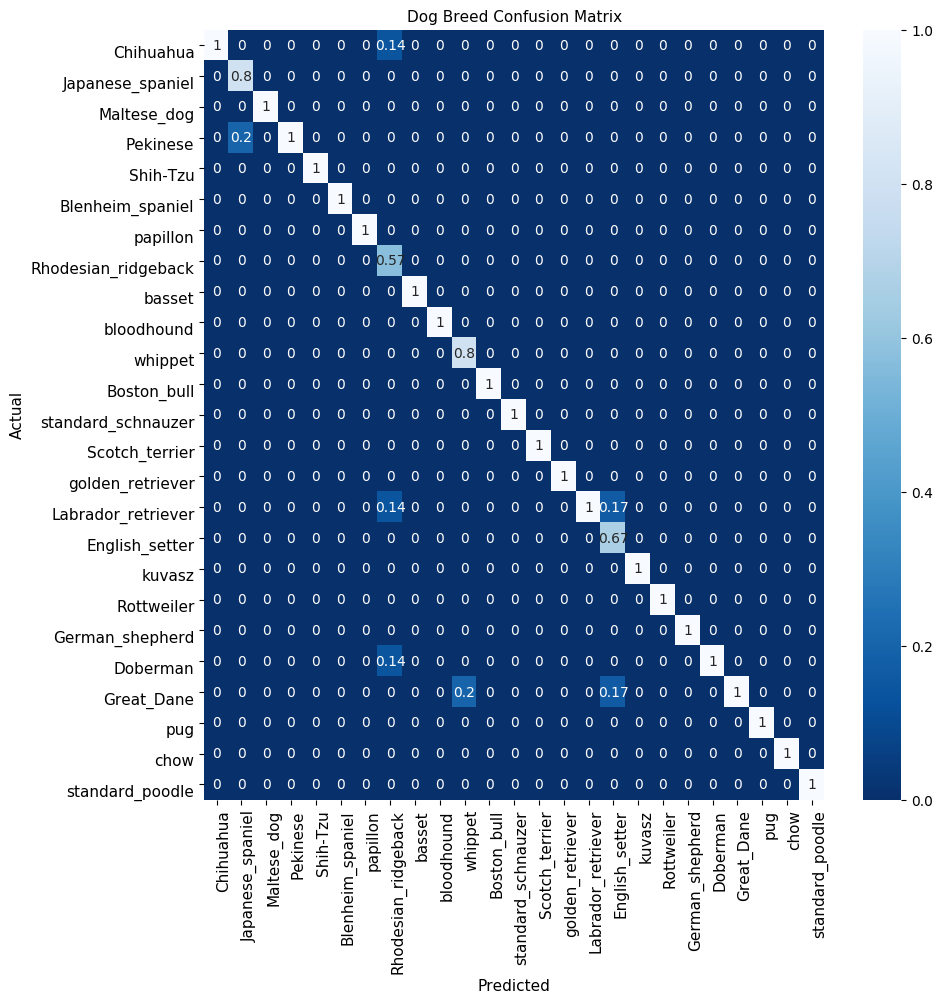

In [471]:
f_size = 11
fig, ax = plt.subplots(1, figsize = (10,10))
sns.heatmap(df_cm, annot=True,cmap="Blues_r", ax = ax)
ax.set_title('Dog Breed Confusion Matrix', fontsize=f_size)
ax.set_xlabel('Predicted', fontsize=f_size)
ax.set_ylabel('Actual', fontsize=f_size)
ax.set_xticklabels(lst_labels, rotation=90, fontsize=f_size, ha='left')
ax.set_yticklabels(lst_labels, fontsize=f_size, va = 'top')

plt.show()

In [ ]:
def plot_missclass(holdout_generator, predictions):
    x,y = holdout_generator.next()
    prediction_labels, real_labels = get_real_pred(predictions, holdout_generator)
    
    incorrect_index = find_missclass_indx(real_labels, prediction_labels)
    fig, axs = plt.subplots(4,2, figsize = (20,20))
    ax = axs.flatten()
    for i, ind in enumerate(incorrect_index):
        rl = real_labels[ind]
        pl = prediction_labels[ind]
        image = x[ind]
        ax[i].set_title('Actual: {}, \n Predicted: {}'.format(rl, pl))
        ax[i].imshow(image)
        ax[i].axis('off')